In [1]:
from __future__ import print_function
from matplotlib import pyplot as plt
plt.switch_backend('agg')
%matplotlib inline
import numpy as np
#import pandas as pd

from IPython.display import display, HTML
import tensorflow as tf
#import numpy as np
#import pandas as pd
#import random as ran
import h5py

import pandas as pd


In [2]:
def Overlap_calc(hp,sp,psd):
    f_low = 20
    m, i = match(hp, sp, psd=psd, low_frequency_cutoff=f_low)
    o = overlap(hp, sp, psd=psd, low_frequency_cutoff=f_low)
    return m


In [41]:
def _preprocess_data(data, num, samples):
    new_array = []
    for i in range(num):
        dataset = data[i]
        if((dataset.max() != 0.0) and (dataset.min() != 0.0)):
            maximum = np.max(dataset)
            minimum = np.abs(np.min(dataset))
            for j in range(samples):
                if(dataset[j] > 0):
                    dataset[j] = dataset[j]/maximum
                else:
                    dataset[j] = dataset[j]/minimum
        new_array.append(dataset)
    return new_array, maximum, minimum


In [165]:
# Split a univariate sequence into samples
#def split_sequence(sequence_noisy,sequence_pure,n_steps):
def split_sequence(sequence_noisy,n_steps):
    X = [] 
#    y = []
    for i in range(len(sequence_noisy)):
    # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix > len(sequence_noisy)-1:
            break
        # gather input and output parts of the pattern
        seq_x = sequence_noisy[i:end_ix] 
#        seq_y = sequence_pure[end_ix]
        X.append(seq_x)
#        y.append(seq_y)
#    return array(X), array(y)
    return np.array(X)
    
    
#def reshape_sequences(self, num, data_noisy, data_pure):
def reshape_sequences(num, data_noisy):
    n_steps = 10
    arr_noisy = []
#    arr_pure = []
        
    for i in range(num):
        X_noisy = data_noisy[i]
#        X_pure = data_pure[i]
        X_noisy = np.pad(X_noisy, (n_steps, n_steps), 'constant', constant_values=(0, 0))
#        X_pure = np.pad(X_pure, (n_steps, n_steps), 'constant', constant_values=(0, 0))
        # split into samples
#        X, y = self.split_sequence(X_noisy, X_pure, n_steps)
        X = split_sequence(X_noisy, n_steps)
        arr_noisy.append(X)
#        arr_pure.append(y)
    
    arr_noisy = np.asarray(arr_noisy)
#    arr_pure = np.asarray(arr_pure)
        
#    return arr_noisy, arr_pure
    return arr_noisy


In [43]:
class FractalTanimotoLoss(tf.keras.losses.Loss):
        def __init__(lr, base_lr=2e-3, depth=0, smooth=1e-6, **kwargs):
            depth = depth
            learning_rate = lr
            base_lr = base_lr
            smooth = smooth
            super().__init__(**kwargs)
    
        def inner_prod(self, y, x):
            prod = y*x
            prod = K.sum(prod, axis=1)
        
            return prod
    
        def tnmt_base(x, y, scale):

            tpl  = inner_prod(y,x)
            tpp  = inner_prod(y,y)
            tll  = inner_prod(x,x)


            num = tpl + self.smooth
            denum = 0.0
            result = 0.0
            for d in range(depth):
                a = 2.**d
                b = -(2.*a-1.)

                denum = denum + tf.math.reciprocal( a*(tpp+tll) + b *tpl + smooth)
                
            result =  num * denum * scale
            
            return  result*scale
        
        def call(y_true, y_pred):
            
            if(learning_rate < base_lr):
                depth = depth + 5
                
            depth = depth+1
            scale = 1./len(range(depth))
            
            l1 = K.mean(K.square(y_pred - y_true),axis=-1)
            result = tnmt_base(y_true, y_pred, scale)
        
            return  l1 - 0.01*result
        
        def get_config(self):
            base_config = super().get_config()
            return {**base_config, "depth": depth}   
    

# GW170104

In [6]:
import pycbc.catalog

c = pycbc.catalog.Catalog(source='gwtc-1')

# Names of mergers in the catalog
print(c.names)

# Approximate GPS time of the mergers
print([c[m].time for m in c])


dict_keys(['GW150914-v3', 'GW151012-v3', 'GW151226-v2', 'GW170104-v2', 'GW170608-v3', 'GW170729-v1', 'GW170809-v1', 'GW170814-v3', 'GW170817-v3', 'GW170818-v1', 'GW170823-v1'])
[1126259462.4, 1128678900.4, 1135136350.6, 1167559936.6, 1180922494.5, 1185389807.3, 1186302519.8, 1186741861.5, 1187008882.4, 1187058327.1, 1187529256.5]


In [166]:
input_data=pd.read_csv("/fred/oz016/Chayan/samplegen_old/output/GW170104_rec_signal_time_L1.dat",header=0,delimiter=" ")


In [167]:
np.where((input_data['#time,'].values > 1167559936.598) & (input_data['#time,'].values < 1167559936.600))[0]


array([15561, 15562, 15563, 15564])

In [168]:
# Lower

15561 -(2048*0.8)

13922.6

In [169]:
# Upper

15561 + (2048*0.2)

15970.6

In [170]:
f1 = h5py.File('/fred/oz016/Chayan/samplegen_old/output/real_events_GW170104.hdf', 'r')
strain = f1['GW170104-v2']['l1_strain'][()]


In [171]:
strain = strain[None,:]

strain, maximum, minimum = _preprocess_data(strain, 1, 2048)

strain = np.array(strain)


In [172]:
X_test_noisy = reshape_sequences(1, strain)

# Reshape arrays to fit into Keras model
X_test_noisy = X_test_noisy[:,:,:,None]
        
print('x_test_noisy shape:', X_test_noisy.shape)

X_test_noisy = X_test_noisy.astype("float32")


x_test_noisy shape: (1, 2058, 10, 1)


In [173]:
#from keras.models import load_model

model = tf.keras.models.load_model('/fred/oz016/Chayan/GW-Denoiser/model/trained_model_test_IMBH_HM_O3b_noise_mass_corrected.h5', custom_objects={'FractalTanimotoLoss': FractalTanimotoLoss})
 
# load model

#model = tf.keras.models.load_model('/fred/oz016/Chayan/GW-Denoiser/model/model_IMRPhenomXPHM_O3b_noise_dilated_CNN_25_timesteps.h5', custom_objects={'FractalTanimotoLoss': FractalTanimotoLoss})
# summarize model.
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 2058, 10, 32)     128       
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 2058, 10, 32)     0         
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 2058, 5, 32)      0         
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 2058, 5, 16)      1552      
 tributed)                                                       
                                                                 
 time_distributed_4 (TimeDis  (None, 2058, 5, 16)      0

In [174]:
decoded_signals = model.predict(X_test_noisy, batch_size=1)


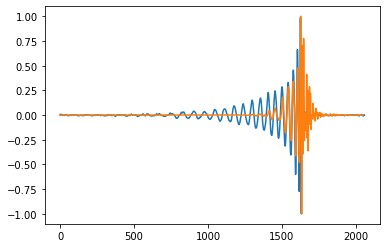

In [175]:
plt.plot(decoded_signals[0])

cwb_reconst = input_data['amp_cwb_point_est,'].values[13923:15971][None,:]
cwb_reconst, maximum, minimum = _preprocess_data(cwb_reconst,1,2048)

plt.plot(cwb_reconst[0])


In [176]:
new_lower = []
for value in input_data['amp_pe_post_lower_90_perc,'].values[13923:15971]:
    if value > 0.0:
        value = value/maximum
    elif value < 0.0:
        value = value/minimum
    new_lower.append(value)
        
new_upper = []
for value in input_data['amp_pe_post_upper_90_perc'].values[13923:15971]:
    if value > 0.0:
        value = value/maximum
    elif value < 0.0:
        value = value/minimum
    new_upper.append(value)
    

In [177]:
with open('/fred/oz016/Chayan/samplegen_old/output/GW170104_L1_psd.dat', 'r') as file:
    freq = []
    psd = []
    for line in file:
        # Split the line into parts based on whitespace or specific delimiter
        parts = line.split()  # Use split('\t') for tab-delimited files
        
        try:
            col1 = float(parts[0])
            col2 = float(parts[1])
            freq.append(col1)
            psd.append(col2)
        except ValueError:
            print(f"Warning: Can't convert line to floats: {line.strip()}")
            
    freq = np.array(freq)
    psd = np.array(psd)


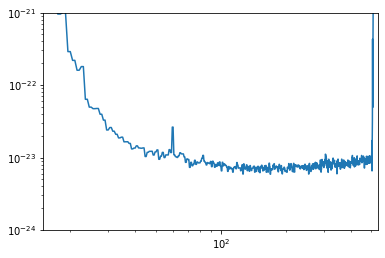

In [178]:
plt.plot(freq, np.sqrt(psd))
plt.xlim(15,)
plt.ylim(1e-24, 1e-21)
plt.xscale('log')
plt.yscale('log')


In [179]:
from pycbc.filter import match, overlap
from pycbc.types.timeseries import TimeSeries, FrequencySeries
import matplotlib.pyplot as plt

def plot_reconstructed(decoded_signals, pure_signals, upper_90, lower_90, psd):
    
#    time_buffer = 104.0/1024
    time_buffer = 1
    length_signal = len(decoded_signals)

    fig = plt.figure(figsize=(10,5))
    
    time = np.linspace(-0.80, 0.20, length_signal)

#    time = np.linspace(-0.80, 0.20, 1024)[920:1024]
    
    
    f_low = 20
    sample_rate = 2048

    # Length of corresponding time series and frequency series
    tlen = int(sample_rate * time_buffer)
    flen = tlen // 2 + 1

    delta_f = 1.0 / time_buffer
#    psd = aLIGOZeroDetHighPower(flen, delta_f, f_low)
    
    X_test_pure_ts = TimeSeries(pure_signals.squeeze(), delta_t = 1.0/2048)
    decoded_signals_ts = TimeSeries(decoded_signals.squeeze(), delta_t = 1.0/2048)
    psd = FrequencySeries(psd, delta_f=delta_f)

    X_test_pure_ts.resize(tlen)
    decoded_signals_ts.resize(tlen)
    psd.resize(flen)

    if(X_test_pure_ts.max() != 0.0):
        m = Overlap_calc(X_test_pure_ts,decoded_signals_ts,psd)
    else:
        m = 1
    
    plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)

    signal_axes = fig.add_subplot(211)
    signal_axes.set_title('Overlap = {m}'.format(m=np.round(m,2)))
    signal_axes.plot(time,pure_signals, linewidth=1.2, label ='cWB maximum likelihood L1 signal')
    signal_axes.plot(time,decoded_signals, linewidth=1.2, label ='ML reconstructed L1 signal', c='red', linestyle='dashed')
    signal_axes.fill_between(time,lower_90,upper_90, color='lightgrey', label='cWB-LALInference 90% C.I.')
    signal_axes.set_ylabel('Rescaled Amplitudes')
    signal_axes.set_xlabel('Time from merger (in secs)')
    signal_axes.legend()
    
    plt.savefig('IMBH_test/O2_real_events/GW170104_reconstruction_CI_dilated_CNN_10_timesteps_L1_cWB_comparison.png', bbox_inches='tight', facecolor='w', transparent=False, dpi=200)


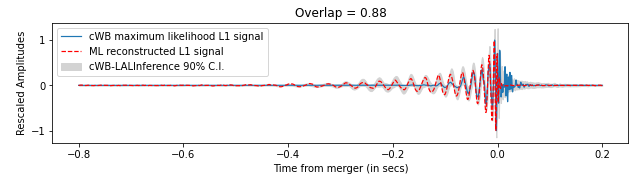

In [180]:
plot_reconstructed(decoded_signals[0][0:2048].astype('float64'), np.squeeze(cwb_reconst).astype('float64'), new_upper, new_lower, psd)


# PE comparison

In [181]:
# Replace 'filename.dat' with your file path
with open('/fred/oz016/Chayan/samplegen_old/output/GW170104_maxl_li_signal_time_L1.dat', 'r') as file:
    time = []
    amp = []
    for line in file:
        # Split the line into parts based on whitespace or specific delimiter
        parts = line.split()  # Use split('\t') for tab-delimited files
        
        try:
            col1 = float(parts[0])
            col2 = float(parts[1])
            time.append(col1)
            amp.append(col2)
        except ValueError:
            print(f"Warning: Can't convert line to floats: {line.strip()}")

time = np.array(time)
amp = np.array(amp)


In [182]:
np.where((time > 1167559936.598) & (time < 1167559936.600))[0]


array([7781, 7782])

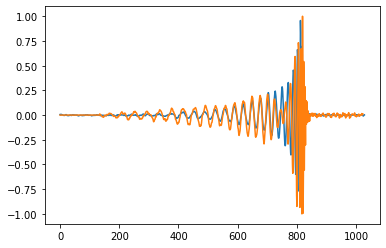

In [183]:
plt.plot(decoded_signals[0][::2])

low_lim = int(7781 - (1024*0.8))
upper_lim = int(7781 + (1024*0.2))

pe_reconst = amp[low_lim:upper_lim][None,:]
pe_reconst, maximum, minimum = _preprocess_data(pe_reconst,1,1024)

plt.plot(pe_reconst[0])


In [184]:
new_lower = []
for value in input_data['amp_pe_post_lower_90_perc,'][::2].values[low_lim:upper_lim]:
    if value > 0.0:
        value = value/maximum
    elif value < 0.0:
        value = value/minimum
    new_lower.append(value)
        
new_upper = []
for value in input_data['amp_pe_post_upper_90_perc'][::2].values[low_lim:upper_lim]:
    if value > 0.0:
        value = value/maximum
    elif value < 0.0:
        value = value/minimum
    new_upper.append(value)
    

In [185]:
from pycbc.filter import match, overlap
from pycbc.types.timeseries import TimeSeries, FrequencySeries
import matplotlib.pyplot as plt

def plot_reconstructed(decoded_signals, pure_signals, upper_90, lower_90, psd):
    
#    time_buffer = 104.0/1024
    time_buffer = 1
    length_signal = len(decoded_signals)

    fig = plt.figure(figsize=(10,5))
    
    time = np.linspace(-0.80, 0.20, length_signal)

#    time = np.linspace(-0.80, 0.20, 1024)[920:1024]
    
    
    f_low = 20
    sample_rate = 1024

    # Length of corresponding time series and frequency series
    tlen = int(sample_rate * time_buffer)
    flen = tlen // 2 + 1

    delta_f = 1.0 / time_buffer
#    psd = aLIGOZeroDetHighPower(flen, delta_f, f_low)
    
    X_test_pure_ts = TimeSeries(pure_signals.squeeze(), delta_t = 1.0/1024)
    decoded_signals_ts = TimeSeries(decoded_signals.squeeze(), delta_t = 1.0/1024)
    psd = FrequencySeries(psd, delta_f=delta_f)

    X_test_pure_ts.resize(tlen)
    decoded_signals_ts.resize(tlen)
    psd.resize(flen)

    if(X_test_pure_ts.max() != 0.0):
        m = Overlap_calc(X_test_pure_ts,decoded_signals_ts,psd)
    else:
        m = 1
    
    plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)

    signal_axes = fig.add_subplot(211)
    signal_axes.set_title('Overlap = {m}'.format(m=np.round(m,2)))
    signal_axes.plot(time,pure_signals, linewidth=1.2, label ='PE maximum likelihood L1 signal')
    signal_axes.plot(time,decoded_signals, linewidth=1.2, label ='ML reconstructed L1 signal', c='red', linestyle='dashed')
    signal_axes.fill_between(time,lower_90,upper_90, color='lightgrey', label='PE-LALInference 90% C.I.')
    signal_axes.set_ylabel('Rescaled Amplitudes')
    signal_axes.set_xlabel('Time from merger (in secs)')
    signal_axes.legend()
    
    plt.savefig('IMBH_test/O2_real_events/GW170104_reconstruction_CI_dilated_CNN_10_timesteps_L1_PE_comparison.png', bbox_inches='tight', facecolor='w', transparent=False, dpi=200)


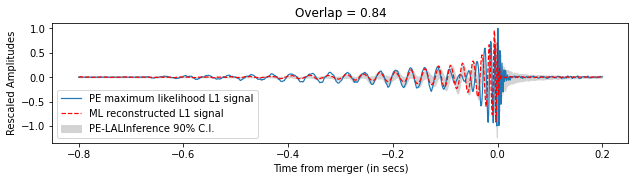

In [186]:
#plot_reconstructed(decoded_signals[0][::2][920:1024].astype(np.float64), np.squeeze(pe_reconst)[920:1024].astype(np.float64), new_upper[920:1024], new_lower[920:1024], psd)

plot_reconstructed(decoded_signals[0][::2][0:1024].astype(np.float64), np.squeeze(pe_reconst)[0:1024].astype(np.float64), new_upper, new_lower, psd)


# GW170809

In [187]:
input_data=pd.read_csv("/fred/oz016/Chayan/samplegen_old/output/GW170809_rec_signal_time_L1.dat",header=0,delimiter=" ")


In [188]:
np.where((input_data['#time,'].values > 1186302519.744) & (input_data['#time,'].values < 1186302519.746))[0]


array([15860, 15861, 15862, 15863])

In [189]:
# Lower

15860 -(2048*0.8)

14221.6

In [190]:
# Upper

15860 + (2048*0.2)

16269.6

In [191]:
f1 = h5py.File('/fred/oz016/Chayan/samplegen_old/output/real_events_GW170809.hdf', 'r')
strain = f1['GW170809-v1']['l1_strain'][()]


In [192]:
strain = strain[None,:]

strain, maximum, minimum = _preprocess_data(strain, 1, 2048)

strain = np.array(strain)


In [193]:
X_test_noisy = reshape_sequences(1, strain)

# Reshape arrays to fit into Keras model
X_test_noisy = X_test_noisy[:,:,:,None]
        
print('x_test_noisy shape:', X_test_noisy.shape)

X_test_noisy = X_test_noisy.astype("float32")


x_test_noisy shape: (1, 2058, 10, 1)


In [194]:
#from keras.models import load_model

model = tf.keras.models.load_model('/fred/oz016/Chayan/GW-Denoiser/model/trained_model_test_IMBH_HM_O3b_noise_mass_corrected.h5', custom_objects={'FractalTanimotoLoss': FractalTanimotoLoss})
 
# load model

#model = tf.keras.models.load_model('/fred/oz016/Chayan/GW-Denoiser/model/model_IMRPhenomXPHM_O3b_noise_dilated_CNN_25_timesteps.h5', custom_objects={'FractalTanimotoLoss': FractalTanimotoLoss})

# summarize model.
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 2058, 10, 32)     128       
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 2058, 10, 32)     0         
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 2058, 5, 32)      0         
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 2058, 5, 16)      1552      
 tributed)                                                       
                                                                 
 time_distributed_4 (TimeDis  (None, 2058, 5, 16)      0

In [195]:
decoded_signals = model.predict(X_test_noisy, batch_size=1)


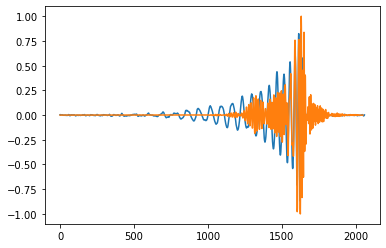

In [196]:
plt.plot(decoded_signals[0])

cwb_reconst = input_data['amp_cwb_point_est,'].values[14222:16270][None,:]
cwb_reconst, maximum, minimum = _preprocess_data(cwb_reconst,1,2048)

plt.plot(cwb_reconst[0])


In [197]:
new_lower = []
for value in input_data['amp_pe_post_lower_90_perc,'].values[14222:16270]:
    if value > 0.0:
        value = value/maximum
    elif value < 0.0:
        value = value/minimum
    new_lower.append(value)
        
new_upper = []
for value in input_data['amp_pe_post_upper_90_perc'].values[14222:16270]:
    if value > 0.0:
        value = value/maximum
    elif value < 0.0:
        value = value/minimum
    new_upper.append(value)
    

In [198]:
with open('/fred/oz016/Chayan/samplegen_old/output/GW170809_L1_psd.dat', 'r') as file:
    freq = []
    psd = []
    for line in file:
        # Split the line into parts based on whitespace or specific delimiter
        parts = line.split()  # Use split('\t') for tab-delimited files
        
        try:
            col1 = float(parts[0])
            col2 = float(parts[1])
            freq.append(col1)
            psd.append(col2)
        except ValueError:
            print(f"Warning: Can't convert line to floats: {line.strip()}")
            
    freq = np.array(freq)
    psd = np.array(psd)


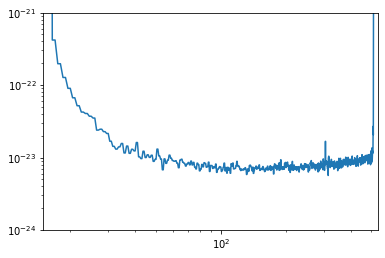

In [199]:
plt.plot(freq, np.sqrt(psd))
plt.xlim(15,)
plt.ylim(1e-24, 1e-21)
plt.xscale('log')
plt.yscale('log')


In [200]:
from pycbc.filter import match, overlap
from pycbc.types.timeseries import TimeSeries, FrequencySeries
import matplotlib.pyplot as plt

def plot_reconstructed(decoded_signals, pure_signals, upper_90, lower_90, psd):
    
#    time_buffer = 104.0/1024
    time_buffer = 1
    length_signal = len(decoded_signals)

    fig = plt.figure(figsize=(10,5))
    
    time = np.linspace(-0.80, 0.20, length_signal)

#    time = np.linspace(-0.80, 0.20, 1024)[920:1024]
    
    
    f_low = 20
    sample_rate = 2048

    # Length of corresponding time series and frequency series
    tlen = int(sample_rate * time_buffer)
    flen = tlen // 2 + 1

    delta_f = 1.0 / time_buffer
#    psd = aLIGOZeroDetHighPower(flen, delta_f, f_low)
    
    X_test_pure_ts = TimeSeries(pure_signals.squeeze(), delta_t = 1.0/2048)
    decoded_signals_ts = TimeSeries(decoded_signals.squeeze(), delta_t = 1.0/2048)
    psd = FrequencySeries(psd, delta_f=delta_f)

    X_test_pure_ts.resize(tlen)
    decoded_signals_ts.resize(tlen)
    psd.resize(flen)

    if(X_test_pure_ts.max() != 0.0):
        m = Overlap_calc(X_test_pure_ts,decoded_signals_ts,psd)
    else:
        m = 1
    
    plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)

    signal_axes = fig.add_subplot(211)
    signal_axes.set_title('Overlap = {m}'.format(m=np.round(m,2)))
    signal_axes.plot(time,pure_signals, linewidth=1.2, label ='cWB maximum likelihood L1 signal')
    signal_axes.plot(time,decoded_signals, linewidth=1.2, label ='ML reconstructed L1 signal', c='red', linestyle='dashed')
    signal_axes.fill_between(time,lower_90,upper_90, color='lightgrey', label='cWB-LALInference 90% C.I.')
    signal_axes.set_ylabel('Rescaled Amplitudes')
    signal_axes.set_xlabel('Time from merger (in secs)')
    signal_axes.legend()
    
    plt.savefig('IMBH_test/O2_real_events/GW170809_reconstruction_CI_dilated_CNN_10_timesteps_L1_cWB_comparison.png', bbox_inches='tight', facecolor='w', transparent=False, dpi=200)


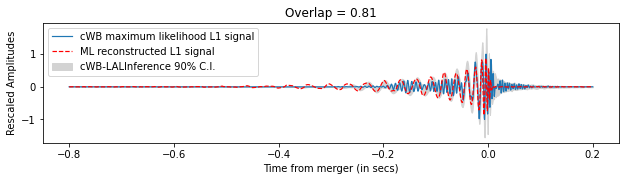

In [202]:
plot_reconstructed(decoded_signals[0][0:2048].astype('float64'), np.squeeze(cwb_reconst).astype('float64'), new_upper, new_lower, psd)


# PE comparison

In [203]:
# Replace 'filename.dat' with your file path
with open('/fred/oz016/Chayan/samplegen_old/output/GW170809_maxl_li_signal_time_L1.dat', 'r') as file:
    time = []
    amp = []
    for line in file:
        # Split the line into parts based on whitespace or specific delimiter
        parts = line.split()  # Use split('\t') for tab-delimited files
        
        try:
            col1 = float(parts[0])
            col2 = float(parts[1])
            time.append(col1)
            amp.append(col2)
        except ValueError:
            print(f"Warning: Can't convert line to floats: {line.strip()}")

time = np.array(time)
amp = np.array(amp)


In [204]:
np.where((time > 1186302519.744) & (time < 1186302519.746))[0]


array([7930, 7931])

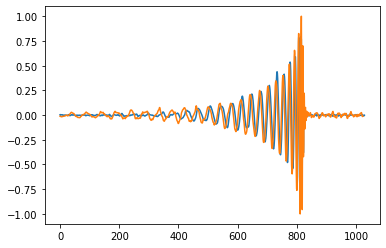

In [205]:
plt.plot(decoded_signals[0][::2])

low_lim = int(7930 - (1024*0.8))
upper_lim = int(7930 + (1024*0.2))

pe_reconst = amp[low_lim:upper_lim][None,:]
pe_reconst, maximum, minimum = _preprocess_data(pe_reconst,1,1024)

plt.plot(pe_reconst[0])


In [206]:
new_lower = []
for value in input_data['amp_pe_post_lower_90_perc,'][::2].values[low_lim:upper_lim]:
    if value > 0.0:
        value = value/maximum
    elif value < 0.0:
        value = value/minimum
    new_lower.append(value)
        
new_upper = []
for value in input_data['amp_pe_post_upper_90_perc'][::2].values[low_lim:upper_lim]:
    if value > 0.0:
        value = value/maximum
    elif value < 0.0:
        value = value/minimum
    new_upper.append(value)
    

In [207]:
from pycbc.filter import match, overlap
from pycbc.types.timeseries import TimeSeries, FrequencySeries
import matplotlib.pyplot as plt

def plot_reconstructed(decoded_signals, pure_signals, upper_90, lower_90, psd):
    
#    time_buffer = 104.0/1024
    time_buffer = 1
    length_signal = len(decoded_signals)

    fig = plt.figure(figsize=(10,5))
    
    time = np.linspace(-0.80, 0.20, length_signal)

#    time = np.linspace(-0.80, 0.20, 1024)[920:1024]
    
    
    f_low = 20
    sample_rate = 1024

    # Length of corresponding time series and frequency series
    tlen = int(sample_rate * time_buffer)
    flen = tlen // 2 + 1

    delta_f = 1.0 / time_buffer
#    psd = aLIGOZeroDetHighPower(flen, delta_f, f_low)
    
    X_test_pure_ts = TimeSeries(pure_signals.squeeze(), delta_t = 1.0/1024)
    decoded_signals_ts = TimeSeries(decoded_signals.squeeze(), delta_t = 1.0/1024)
    psd = FrequencySeries(psd, delta_f=delta_f)

    X_test_pure_ts.resize(tlen)
    decoded_signals_ts.resize(tlen)
    psd.resize(flen)

    if(X_test_pure_ts.max() != 0.0):
        m = Overlap_calc(X_test_pure_ts,decoded_signals_ts,psd)
    else:
        m = 1
    
    plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)

    signal_axes = fig.add_subplot(211)
    signal_axes.set_title('Overlap = {m}'.format(m=np.round(m,2)))
    signal_axes.plot(time,pure_signals, linewidth=1.2, label ='PE maximum likelihood L1 signal')
    signal_axes.plot(time,decoded_signals, linewidth=1.2, label ='ML reconstructed L1 signal', c='red', linestyle='dashed')
    signal_axes.fill_between(time,lower_90,upper_90, color='lightgrey', label='PE-LALInference 90% C.I.')
    signal_axes.set_ylabel('Rescaled Amplitudes')
    signal_axes.set_xlabel('Time from merger (in secs)')
    signal_axes.legend()
    
    plt.savefig('IMBH_test/O2_real_events/GW170809_reconstruction_CI_dilated_CNN_10_timesteps_L1_PE_comparison.png', bbox_inches='tight', facecolor='w', transparent=False, dpi=200)


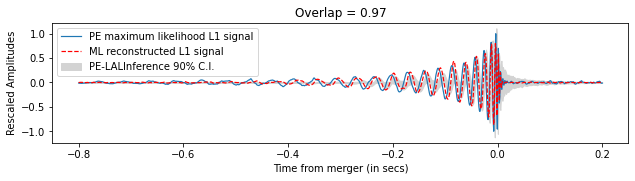

In [208]:
#plot_reconstructed(decoded_signals[0][::2][920:1024].astype(np.float64), np.squeeze(pe_reconst)[920:1024].astype(np.float64), new_upper[920:1024], new_lower[920:1024], psd)

plot_reconstructed(decoded_signals[0][::2][0:1024].astype(np.float64), np.squeeze(pe_reconst)[0:1024].astype(np.float64), new_upper, new_lower, psd)


# GW170814

In [358]:
input_data=pd.read_csv("/fred/oz016/Chayan/samplegen_old/output/GW170814_rec_signal_time_L1_1.dat",header=0,delimiter=" ")


In [359]:
np.where((input_data['#time,'].values > 1186741861.522) & (input_data['#time,'].values < 1186741861.524))[0]


array([7703, 7704])

In [360]:
1.0/(input_data['#time,'].values[1] - input_data['#time,'].values[0])

1024.250061050061

In [361]:
# Lower

7703 -(1024*0.8)

6883.8

In [362]:
# Upper

7703 + (1024*0.2)

7907.8

In [363]:
f1 = h5py.File('/fred/oz016/Chayan/samplegen_old/output/real_events_GW170814.hdf', 'r')
strain = f1['GW170814-v3']['l1_strain'][()]


In [364]:
strain = strain[None,:]

strain, maximum, minimum = _preprocess_data(strain, 1, 2048)

strain = np.array(strain)


In [365]:
X_test_noisy = reshape_sequences(1, strain)

# Reshape arrays to fit into Keras model
X_test_noisy = X_test_noisy[:,:,:,None]
        
print('x_test_noisy shape:', X_test_noisy.shape)

X_test_noisy = X_test_noisy.astype("float32")


x_test_noisy shape: (1, 2058, 10, 1)


In [366]:
#from keras.models import load_model

model = tf.keras.models.load_model('/fred/oz016/Chayan/GW-Denoiser/model/trained_model_test_IMBH_HM_O3b_noise_mass_corrected.h5', custom_objects={'FractalTanimotoLoss': FractalTanimotoLoss})
 
# load model

#model = tf.keras.models.load_model('/fred/oz016/Chayan/GW-Denoiser/model/model_IMRPhenomXPHM_O3b_noise_dilated_CNN_25_timesteps.h5', custom_objects={'FractalTanimotoLoss': FractalTanimotoLoss})

# summarize model.
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 2058, 10, 32)     128       
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 2058, 10, 32)     0         
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 2058, 5, 32)      0         
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 2058, 5, 16)      1552      
 tributed)                                                       
                                                                 
 time_distributed_4 (TimeDis  (None, 2058, 5, 16)      0

In [368]:
decoded_signals = model.predict(X_test_noisy, batch_size=1)


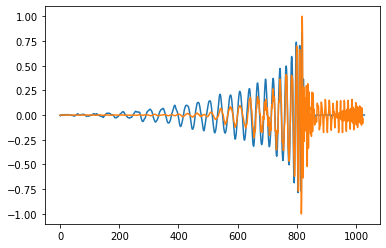

In [369]:
plt.plot(decoded_signals[0][::2])

#cwb_reconst = input_data['amp_cwb_point_est,'].values[13771:15819][None,:]
cwb_reconst = input_data['amp_cwb_rec,'].values[6884:7908][None,:]
cwb_reconst, maximum, minimum = _preprocess_data(cwb_reconst,1,1024)

plt.plot(cwb_reconst[0])


In [370]:
new_lower = []
for value in input_data['amp_post_lower_90_cr,'].values[6884:7908]:
    if value > 0.0:
        value = value/maximum
    elif value < 0.0:
        value = value/minimum
    new_lower.append(value)
        
new_upper = []
for value in input_data['amp_post_upper_90_cr'].values[6884:7908]:
    if value > 0.0:
        value = value/maximum
    elif value < 0.0:
        value = value/minimum
    new_upper.append(value)
    

In [371]:
with open('/fred/oz016/Chayan/samplegen_old/output/GW170814_L1_psd.dat', 'r') as file:
    freq = []
    psd = []
    for line in file:
        # Split the line into parts based on whitespace or specific delimiter
        parts = line.split()  # Use split('\t') for tab-delimited files
        
        try:
            col1 = float(parts[0])
            col2 = float(parts[1])
            freq.append(col1)
            psd.append(col2)
        except ValueError:
            print(f"Warning: Can't convert line to floats: {line.strip()}")
            
    freq = np.array(freq)
    psd = np.array(psd)


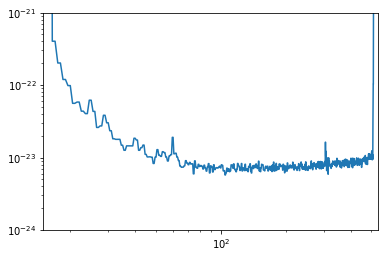

In [372]:
plt.plot(freq, np.sqrt(psd))
plt.xlim(15,)
plt.ylim(1e-24, 1e-21)
plt.xscale('log')
plt.yscale('log')


In [373]:
from pycbc.filter import match, overlap
from pycbc.types.timeseries import TimeSeries, FrequencySeries
import matplotlib.pyplot as plt

def plot_reconstructed(decoded_signals, pure_signals, upper_90, lower_90, psd):
    
#    time_buffer = 104.0/1024
    time_buffer = 1
    length_signal = len(decoded_signals)

    fig = plt.figure(figsize=(10,5))
    
    time = np.linspace(-0.80, 0.20, length_signal)

#    time = np.linspace(-0.80, 0.20, 1024)[920:1024]
    
    
    f_low = 20
    sample_rate = 1024

    # Length of corresponding time series and frequency series
    tlen = int(sample_rate * time_buffer)
    flen = tlen // 2 + 1

    delta_f = 1.0 / time_buffer
#    psd = aLIGOZeroDetHighPower(flen, delta_f, f_low)
    
    X_test_pure_ts = TimeSeries(pure_signals.squeeze(), delta_t = 1.0/1024)
    decoded_signals_ts = TimeSeries(decoded_signals.squeeze(), delta_t = 1.0/1024)
    psd = FrequencySeries(psd, delta_f=delta_f)

    X_test_pure_ts.resize(tlen)
    decoded_signals_ts.resize(tlen)
    psd.resize(flen)

    if(X_test_pure_ts.max() != 0.0):
        m = Overlap_calc(X_test_pure_ts,decoded_signals_ts,psd)
    else:
        m = 1
    
    plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)

    signal_axes = fig.add_subplot(211)
    signal_axes.set_title('Overlap = {m}'.format(m=np.round(m,2)))
    signal_axes.plot(time,pure_signals, linewidth=1.2, label ='cWB maximum likelihood L1 signal')
    signal_axes.plot(time,decoded_signals, linewidth=1.2, label ='ML reconstructed L1 signal', c='red', linestyle='dashed')
    signal_axes.fill_between(time,lower_90,upper_90, color='lightgrey', label='cWB-LALInference 90% C.I.')
    signal_axes.set_ylabel('Rescaled Amplitudes')
    signal_axes.set_xlabel('Time from merger (in secs)')
    signal_axes.legend()
    
    plt.savefig('IMBH_test/O2_real_events/GW170814_reconstruction_CI_dilated_CNN_10_timesteps_L1_cWB_comparison.png', bbox_inches='tight', facecolor='w', transparent=False, dpi=200)


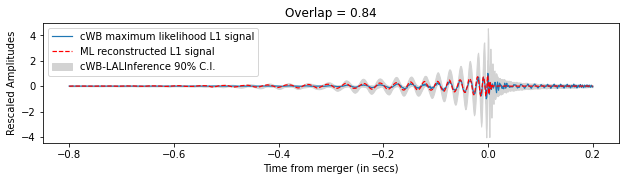

In [374]:
plot_reconstructed(decoded_signals[0][::2][0:1024].astype('float64'), np.squeeze(cwb_reconst).astype('float64'), new_upper, new_lower, psd)


# PE comparison

In [375]:
# Replace 'filename.dat' with your file path
with open('/fred/oz016/Chayan/samplegen_old/output/GW170814_maxl_li_signal_time_L1.dat', 'r') as file:
    time = []
    amp = []
    for line in file:
        # Split the line into parts based on whitespace or specific delimiter
        parts = line.split()  # Use split('\t') for tab-delimited files
        
        try:
            col1 = float(parts[0])
            col2 = float(parts[1])
            time.append(col1)
            amp.append(col2)
        except ValueError:
            print(f"Warning: Can't convert line to floats: {line.strip()}")

time = np.array(time)
amp = np.array(amp)


In [376]:
np.where((time > 1186741861.522) & (time < 1186741861.524))[0]


array([7703, 7704])

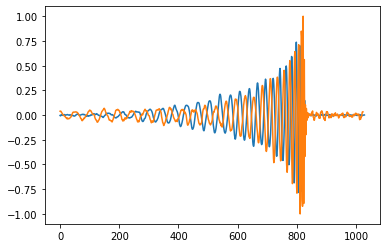

In [377]:
plt.plot(decoded_signals[0][::2])

pe_reconst = amp[6884:7908][None,:]
pe_reconst, maximum, minimum = _preprocess_data(pe_reconst,1,1024)

plt.plot(pe_reconst[0])


In [378]:
new_lower = []
for value in input_data['amp_post_lower_90_cr,'].values[6884:7908]:
    if value > 0.0:
        value = value/maximum
    elif value < 0.0:
        value = value/minimum
    new_lower.append(value)
        
new_upper = []
for value in input_data['amp_post_upper_90_cr'].values[6884:7908]:
    if value > 0.0:
        value = value/maximum
    elif value < 0.0:
        value = value/minimum
    new_upper.append(value)
    

In [379]:
from pycbc.filter import match, overlap
from pycbc.types.timeseries import TimeSeries, FrequencySeries
import matplotlib.pyplot as plt

def plot_reconstructed(decoded_signals, pure_signals, upper_90, lower_90, psd):
    
#    time_buffer = 104.0/1024
    time_buffer = 1
    length_signal = len(decoded_signals)

    fig = plt.figure(figsize=(10,5))
    
    time = np.linspace(-0.80, 0.20, length_signal)

#    time = np.linspace(-0.80, 0.20, 1024)[920:1024]
    
    
    f_low = 20
    sample_rate = 1024

    # Length of corresponding time series and frequency series
    tlen = int(sample_rate * time_buffer)
    flen = tlen // 2 + 1

    delta_f = 1.0 / time_buffer
#    psd = aLIGOZeroDetHighPower(flen, delta_f, f_low)
    
    X_test_pure_ts = TimeSeries(pure_signals.squeeze(), delta_t = 1.0/1024)
    decoded_signals_ts = TimeSeries(decoded_signals.squeeze(), delta_t = 1.0/1024)
    psd = FrequencySeries(psd, delta_f=delta_f)

    X_test_pure_ts.resize(tlen)
    decoded_signals_ts.resize(tlen)
    psd.resize(flen)

    if(X_test_pure_ts.max() != 0.0):
        m = Overlap_calc(X_test_pure_ts,decoded_signals_ts,psd)
    else:
        m = 1
    
    plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)

    signal_axes = fig.add_subplot(211)
    signal_axes.set_title('Overlap = {m}'.format(m=np.round(m,2)))
    signal_axes.plot(time,pure_signals, linewidth=1.2, label ='PE maximum likelihood L1 signal')
    signal_axes.plot(time,decoded_signals, linewidth=1.2, label ='ML reconstructed L1 signal', c='red', linestyle='dashed')
    signal_axes.fill_between(time,lower_90,upper_90, color='lightgrey', label='PE-LALInference 90% C.I.')
    signal_axes.set_ylabel('Rescaled Amplitudes')
    signal_axes.set_xlabel('Time from merger (in secs)')
    signal_axes.legend()
    
    plt.savefig('IMBH_test/O2_real_events/GW170814_reconstruction_CI_dilated_CNN_10_timesteps_L1_PE_comparison.png', bbox_inches='tight', facecolor='w', transparent=False, dpi=200)


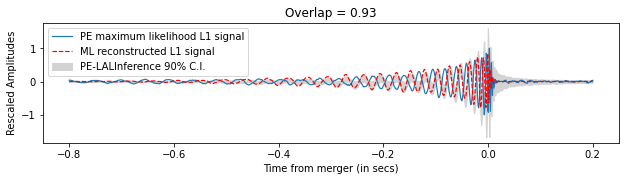

In [380]:
#plot_reconstructed(decoded_signals[0][::2][920:1024].astype(np.float64), np.squeeze(pe_reconst)[920:1024].astype(np.float64), new_upper[920:1024], new_lower[920:1024], psd)

plot_reconstructed(decoded_signals[0][::2][0:1024].astype(np.float64), np.squeeze(pe_reconst)[0:1024].astype(np.float64), new_upper[0:1024], new_lower[0:1024], psd)


# GW170818

In [166]:
input_data=pd.read_csv("/fred/oz016/Chayan/samplegen_old/output/GW170818_rec_signal_time_L1.dat",header=0,delimiter=" ")


In [167]:
np.where((input_data['#time,'].values > 1187058327.079) & (input_data['#time,'].values < 1187058327.081))[0]


array([16546, 16547, 16548, 16549])

In [168]:
# Lower

16546 -(2048*0.8)

14907.6

In [169]:
# Upper

16546 + (2048*0.2)

16955.6

In [170]:
f1 = h5py.File('/fred/oz016/Chayan/samplegen_old/output/real_events_GW170818.hdf', 'r')
strain = f1['GW170818-v1']['l1_strain'][()]


In [171]:
strain = strain[None,:]

strain, maximum, minimum = _preprocess_data(strain, 1, 2048)

strain = np.array(strain)


In [172]:
X_test_noisy = reshape_sequences(1, strain)

# Reshape arrays to fit into Keras model
X_test_noisy = X_test_noisy[:,:,:,None]
        
print('x_test_noisy shape:', X_test_noisy.shape)

X_test_noisy = X_test_noisy.astype("float32")


x_test_noisy shape: (1, 2058, 10, 1)


In [173]:
#from keras.models import load_model

model = tf.keras.models.load_model('/fred/oz016/Chayan/GW-Denoiser/model/trained_model_test_IMBH_HM_O3b_noise_mass_corrected.h5', custom_objects={'FractalTanimotoLoss': FractalTanimotoLoss})
 
# load model

#model = tf.keras.models.load_model('/fred/oz016/Chayan/GW-Denoiser/model/model_IMRPhenomXPHM_O3b_noise_dilated_CNN_25_timesteps.h5', custom_objects={'FractalTanimotoLoss': FractalTanimotoLoss})

# summarize model.
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 2058, 10, 32)     128       
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 2058, 10, 32)     0         
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 2058, 5, 32)      0         
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 2058, 5, 16)      1552      
 tributed)                                                       
                                                                 
 time_distributed_4 (TimeDis  (None, 2058, 5, 16)      0

In [174]:
decoded_signals = model.predict(X_test_noisy, batch_size=1)


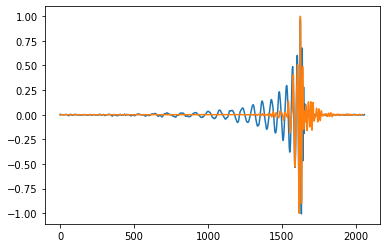

In [175]:
plt.plot(decoded_signals[0])

cwb_reconst = input_data['amp_cwb_point_est,'].values[14908:16956][None,:]
cwb_reconst, maximum, minimum = _preprocess_data(cwb_reconst,1,2048)

plt.plot(cwb_reconst[0])


In [176]:
new_lower = []
for value in input_data['amp_pe_post_lower_90_perc,'].values[14908:16956]:
    if value > 0.0:
        value = value/maximum
    elif value < 0.0:
        value = value/minimum
    new_lower.append(value)
        
new_upper = []
for value in input_data['amp_pe_post_upper_90_perc'].values[14908:16956]:
    if value > 0.0:
        value = value/maximum
    elif value < 0.0:
        value = value/minimum
    new_upper.append(value)
    

In [177]:
from pycbc.types.timeseries import TimeSeries
import matplotlib.pyplot as plt

def plot_reconstructed(decoded_signals, pure_signals, upper_90, lower_90):
    
    length_signal = len(decoded_signals)

    fig = plt.figure(figsize=(10,5))

    time = np.linspace(-0.80, 0.20, length_signal)

    plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)

    signal_axes = fig.add_subplot(211)
    signal_axes.plot(time,pure_signals, linewidth=1.2, label ='cWB maximum likelihood L1 signal')
    signal_axes.plot(time,decoded_signals, linewidth=1.2, label ='ML reconstructed L1 signal', c='red', linestyle='dashed')
    signal_axes.fill_between(time,lower_90,upper_90, color='lightgrey', label='cWB-LALInference 90% C.I.')
    signal_axes.set_ylabel('Rescaled Amplitudes')
    signal_axes.legend()
    
    plt.savefig('IMBH_test/O2_real_events/GW170818_reconstruction_CI_dilated_CNN_10_timesteps_L1.png', bbox_inches='tight', facecolor='w', transparent=False, dpi=200)


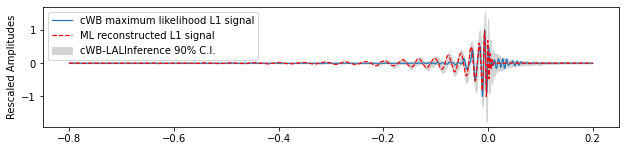

In [178]:
plot_reconstructed(decoded_signals[0][0:2048], np.squeeze(cwb_reconst), new_upper, new_lower)


# GW170823

In [197]:
input_data=pd.read_csv("/fred/oz016/Chayan/samplegen_old/output/GW170823_rec_signal_time_L1.dat",header=0,delimiter=" ")


In [198]:
np.where((input_data['#time,'].values > 1187529256.516) & (input_data['#time,'].values < 1187529256.518))[0]


array([15393, 15394, 15395, 15396])

In [199]:
# Lower

15393 -(2048*0.8)

13754.6

In [200]:
# Upper

15393 + (2048*0.2)

15802.6

In [201]:
f1 = h5py.File('/fred/oz016/Chayan/samplegen_old/output/real_events_GW170823.hdf', 'r')
strain = f1['GW170823-v1']['l1_strain'][()]


In [202]:
strain = strain[None,:]

strain, maximum, minimum = _preprocess_data(strain, 1, 2048)

strain = np.array(strain)


In [203]:
X_test_noisy = reshape_sequences(1, strain)

# Reshape arrays to fit into Keras model
X_test_noisy = X_test_noisy[:,:,:,None]
        
print('x_test_noisy shape:', X_test_noisy.shape)

X_test_noisy = X_test_noisy.astype("float32")


x_test_noisy shape: (1, 2058, 10, 1)


In [204]:
#from keras.models import load_model

model = tf.keras.models.load_model('/fred/oz016/Chayan/GW-Denoiser/model/trained_model_test_IMBH_HM_O3b_noise_mass_corrected.h5', custom_objects={'FractalTanimotoLoss': FractalTanimotoLoss})
 
# load model

#model = tf.keras.models.load_model('/fred/oz016/Chayan/GW-Denoiser/model/model_IMRPhenomXPHM_O3b_noise_dilated_CNN_25_timesteps.h5', custom_objects={'FractalTanimotoLoss': FractalTanimotoLoss})

# summarize model.
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 2058, 10, 32)     128       
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 2058, 10, 32)     0         
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 2058, 5, 32)      0         
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 2058, 5, 16)      1552      
 tributed)                                                       
                                                                 
 time_distributed_4 (TimeDis  (None, 2058, 5, 16)      0

In [205]:
decoded_signals = model.predict(X_test_noisy, batch_size=1)


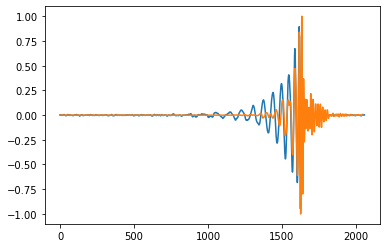

In [206]:
plt.plot(decoded_signals[0])

cwb_reconst = input_data['amp_cwb_point_est,'].values[13755:15803][None,:]
cwb_reconst, maximum, minimum = _preprocess_data(cwb_reconst,1,2048)

plt.plot(cwb_reconst[0])


In [207]:
new_lower = []
for value in input_data['amp_pe_post_lower_90_perc,'].values[13755:15803]:
    if value > 0.0:
        value = value/maximum
    elif value < 0.0:
        value = value/minimum
    new_lower.append(value)
        
new_upper = []
for value in input_data['amp_pe_post_upper_90_perc'].values[13755:15803]:
    if value > 0.0:
        value = value/maximum
    elif value < 0.0:
        value = value/minimum
    new_upper.append(value)
    

In [208]:
from pycbc.types.timeseries import TimeSeries
import matplotlib.pyplot as plt

def plot_reconstructed(decoded_signals, pure_signals, upper_90, lower_90):
    
    length_signal = len(decoded_signals)

    fig = plt.figure(figsize=(10,5))

    time = np.linspace(-0.80, 0.20, length_signal)

    plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)

    signal_axes = fig.add_subplot(211)
    signal_axes.plot(time,pure_signals, linewidth=1.2, label ='cWB maximum likelihood L1 signal')
    signal_axes.plot(time,decoded_signals, linewidth=1.2, label ='ML reconstructed L1 signal', c='red', linestyle='dashed')
    signal_axes.fill_between(time,lower_90,upper_90, color='lightgrey', label='cWB-LALInference 90% C.I.')
    signal_axes.set_ylabel('Rescaled Amplitudes')
    signal_axes.legend()
    
    plt.savefig('IMBH_test/O2_real_events/GW170823_reconstruction_CI_dilated_CNN_10_timesteps_L1.png', bbox_inches='tight', facecolor='w', transparent=False, dpi=200)


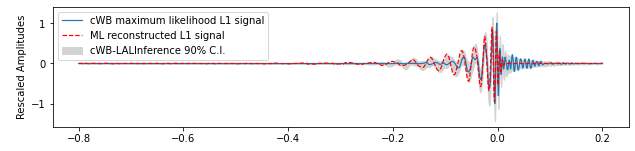

In [209]:
plot_reconstructed(decoded_signals[0][0:2048], np.squeeze(cwb_reconst), new_upper, new_lower)
